# YOLO Patch-Based Inference (SAHI) によるセグメンテーション検出

このノートブックでは、`patched-yolo-infer`ライブラリを使用して、パッチベースの推論でインスタンスセグメンテーションを実行します。

## 特徴
- 🎯 小さなオブジェクトの検出精度が向上
- 📐 画像をパッチ（クロップ）に分割して推論
- 🎨 高品質なインスタンスセグメンテーション
- 🔄 重複検出の自動抑制


In [147]:
# 必要なライブラリのインポート
from ultralytics import YOLO
import cv2
import os
import glob
from pathlib import Path
import numpy as np
from PIL import Image
import imageio
from tqdm import tqdm
from patched_yolo_infer import (
    MakeCropsDetectThem, 
    CombineDetections, 
    visualize_results
)

print("ライブラリのインポート完了")


ライブラリのインポート完了


## 1. 設定


In [148]:
# モデル読み込み
model_path = r"D:\prog_py\Yolo_trainer\runs\train\yolo12n-seg-pod\weights\best.pt"
model = YOLO(model_path)

# パス設定
source_path = "detect_images"
base_dir = "runs/detect/sahi_results"

# 連番付きディレクトリを作成
i = 1
while True:
    output_dir = f"{base_dir}{i}" if i > 1 else base_dir
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        break
    i += 1

# パッチパラメータ
shape_x = 320
shape_y = 320
overlap_x = 40     # %
overlap_y = 40     # %

# 推論パラメータ
conf_threshold = 0.5
imgsz = 640

print(f"設定: {shape_x}x{shape_y}, overlap={overlap_x}%, conf={conf_threshold}")
print(f"保存先: {output_dir}")


設定: 320x320, overlap=40%, conf=0.5
保存先: runs/detect/sahi_results


## 2. 画像リスト


In [149]:
# 画像ファイル取得
image_files = glob.glob(os.path.join(source_path, "*.jpg")) + \
              glob.glob(os.path.join(source_path, "*.png")) + \
              glob.glob(os.path.join(source_path, "*.jpeg"))

print(f"画像数: {len(image_files)}枚")


画像数: 13枚


## 3. パッチベース推論の実行

`batch_inference=True`により、複数のパッチを一度にバッチ処理します（高速化、GPU使用量↑）。


In [150]:
# 各画像に対して推論を実行
from collections import Counter

for idx, img_path in enumerate(image_files):
    print(f"\n[{idx+1}/{len(image_files)}] {Path(img_path).name}")
    
    img = cv2.imread(img_path)
    if img is None:
        print("❌ エラー")
        continue
    
    # パッチベース推論（バッチ処理）
    element_crops = MakeCropsDetectThem(
        image=img,
        model=model,
        segment=True,
        shape_x=shape_x,
        shape_y=shape_y,
        overlap_x=overlap_x,
        overlap_y=overlap_y,
        conf=conf_threshold,
        imgsz=imgsz,
        show_crops=False,
        memory_optimize=False,
        batch_inference=True,          # バッチ推論（高速化）
        show_processing_status=True,
    )
    
    # 結果結合とNMS
    result = CombineDetections(
        element_crops, 
        nms_threshold=0.3,
        class_agnostic_nms=False,
    )
    
    # 検出結果
    confidences = result.filtered_confidences
    boxes = result.filtered_boxes
    masks = result.filtered_masks
    classes_ids = result.filtered_classes_id
    classes_names = result.filtered_classes_names
    
    # 結果表示
    class_counts = Counter(classes_names)
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count}個")
    
    # 可視化（大きめ設定）
    result_img = visualize_results(
        img=img,
        boxes=boxes,
        classes_ids=classes_ids,
        confidences=confidences,
        classes_names=classes_names,
        masks=masks,
        segment=True,
        show_boxes=True,
        show_class=False,
        fill_mask=True,
        alpha=0.7,
        thickness=1,              # 線を太く
        font_scale=2.0,           # 文字を大きく
        show_confidences=True,
        return_image_array=True,
        random_object_colors=True,
    )
    
    # 保存
    output_path = os.path.join(output_dir, Path(img_path).name)
    cv2.imwrite(output_path, result_img)

print(f"\n✅ 完了！結果: {output_dir}")



[1/13] Image_000003.jpg


Detecting objects in batch: 100%|██████████| 1/1 [00:02<00:00,  2.20s/items]


  pod: 75個

[2/13] Image_000118.jpg


Detecting objects in batch: 100%|██████████| 1/1 [00:02<00:00,  2.30s/items]


  pod: 74個

[3/13] Image_000188.jpg


Detecting objects in batch: 100%|██████████| 1/1 [00:01<00:00,  1.77s/items]


  pod: 58個

[4/13] Image_000473.jpg


Detecting objects in batch: 100%|██████████| 1/1 [00:00<00:00,  1.01items/s]


  pod: 52個

[5/13] Image_000565.jpg


Detecting objects in batch: 100%|██████████| 1/1 [00:03<00:00,  3.89s/items]


  pod: 86個

[6/13] Image_000896.jpg


Detecting objects in batch: 100%|██████████| 1/1 [00:01<00:00,  1.95s/items]


  pod: 67個

[7/13] Image_001075.jpg


Detecting objects in batch: 100%|██████████| 1/1 [00:01<00:00,  1.45s/items]


  pod: 51個

[8/13] Image_001845.jpg


Detecting objects in batch: 100%|██████████| 1/1 [00:00<00:00,  1.09items/s]


  pod: 47個

[9/13] Image_001851.jpg


Detecting objects in batch: 100%|██████████| 1/1 [00:00<00:00,  1.20items/s]


  pod: 26個

[10/13] Image_001885.jpg


Detecting objects in batch: 100%|██████████| 1/1 [00:00<00:00,  2.58items/s]


  pod: 28個

[11/13] Image_001997.jpg


Detecting objects in batch: 100%|██████████| 1/1 [00:02<00:00,  2.54s/items]


  pod: 99個

[12/13] Image_002005.jpg


Detecting objects in batch: 100%|██████████| 1/1 [00:00<00:00,  1.18items/s]


  pod: 51個

[13/13] Image_002036.jpg


Detecting objects in batch: 100%|██████████| 1/1 [00:01<00:00,  1.56s/items]


  pod: 54個

✅ 完了！結果: runs/detect/sahi_results


## 4. （オプション）パッチ分割の可視化

パッチがどのように分割されているかを確認します。小さめのパッチサイズ（320x320）で複数のパッチを生成して表示します。


パッチ可視化: Image_000003.jpg
画像サイズ: 958x1065


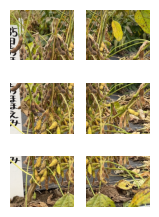

Number of generated images: 6
生成されたパッチ数: 6個


In [151]:
# パッチ分割の可視化確認
if len(image_files) > 0:
    test_img = cv2.imread(image_files[0])
    
    print(f"パッチ可視化: {Path(image_files[0]).name}")
    print(f"画像サイズ: {test_img.shape[1]}x{test_img.shape[0]}")
    
    # パッチを複数生成するために小さめのサイズで可視化
    element_crops_test = MakeCropsDetectThem(
        image=test_img,
        model=model,
        segment=True,
        shape_x=500,              # 小さくしてパッチを複数生成
        shape_y=400,
        overlap_x=30,
        overlap_y=30,
        conf=conf_threshold,
        imgsz=imgsz,
        show_crops=True,          # パッチ可視化
        memory_optimize=False,
        show_processing_status=False,
    )
    
    print(f"生成されたパッチ数: {len(element_crops_test.crops)}個")


## 5. （オプション）検出過程のGIFアニメーション作成

各パッチでの検出過程をステップバイステップで可視化し、GIFアニメーションとして保存します。


In [152]:
# 検出過程のGIFアニメーション作成（滑らかバージョン）
if len(image_files) > 0:
    # 1枚目の画像で検出過程を可視化
    test_img_path = image_files[0]
    test_img = cv2.imread(test_img_path)
    
    print(f"🎬 高品質GIF作成中: {Path(test_img_path).name}")
    
    # パッチベース推論（バッチ処理なしで各パッチを個別に処理）
    element_crops = MakeCropsDetectThem(
        image=test_img,
        model=model,
        segment=True,
        shape_x=shape_x,
        shape_y=shape_y,
        overlap_x=overlap_x,
        overlap_y=overlap_y,
        conf=conf_threshold,
        imgsz=imgsz,
        show_crops=False,
        memory_optimize=False,
        batch_inference=False,  # 順次処理でアニメーション用
        show_processing_status=False,
    )
    
    # フレームリスト（RGB形式）
    frames = []
    
    # ========== アニメーション設定 ==========
    FRAME_INITIAL = 15       # 初期画像
    FRAME_FIRST_FADE = 10    # 最初のパッチフェードイン
    FRAME_SLIDE = 8          # パッチスライド
    FRAME_DETECT = 5         # 検出中
    FRAME_FADE_IN = 8        # 検出結果フェードイン
    FRAME_PAUSE = 2          # 検出後の停止
    FRAME_NMS_BEFORE = 15    # NMS前
    FRAME_TRANSITION = 12    # 遷移
    FRAME_FINAL = 60         # 最終結果
    
    ALPHA_PAST = 0.15        # 過去のパッチ
    ALPHA_CURRENT = 0.75     # 現在のパッチ
    
    # ========== ヘルパー関数 ==========
    
    def draw_detections(img, detections_list):
        """検出結果（ボックス+マスク）を描画"""
        result = img.copy()
        for boxes, masks in detections_list:
            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(result, (x1, y1), (x2, y2), (0, 255, 0), 1)
                
                if i < len(masks):
                    mask = masks[i]
                    if mask.shape != result.shape[:2]:
                        mask = cv2.resize(mask, (result.shape[1], result.shape[0]),
                                        interpolation=cv2.INTER_NEAREST)
                    colored_mask = np.zeros_like(result)
                    colored_mask[mask > 0] = [0, 200, 0]
                    result = cv2.addWeighted(result, 1, colored_mask, 0.35, 0)
        return result
    
    def get_patch_regions(crops):
        """すべてのパッチの座標を取得（リサイズ後の画像ベース）"""
        patch_regions = []
        for crop in crops:
            # リサイズされた画像上の座標を使用
            h, w = crop.source_image_resized.shape[:2]
            x_min = max(0, int(crop.x_start))
            y_min = max(0, int(crop.y_start))
            crop_h, crop_w = crop.crop.shape[:2]
            x_max = min(w, int(crop.x_start + crop_w))
            y_max = min(h, int(crop.y_start + crop_h))
            patch_regions.append((x_min, y_min, x_max, y_max))
        return patch_regions
    
    # ヘルパー関数: オーバーラップマップを作成
    def create_overlap_map(patch_regions, img_shape):
        h, w = img_shape[:2]
        overlap_map = np.zeros((h, w), dtype=np.uint8)
        for x_min, y_min, x_max, y_max in patch_regions:
            overlap_map[y_min:y_max, x_min:x_max] += 1
        return overlap_map
    
    # ヘルパー関数: パッチを描画（オーバーラップ対応）
    def draw_single_patch(img, region, overlap_map, alpha, show_overlap=True):
        """
        単一のパッチを描画（オーバーラップ部分は濃く）
        """
        result = img.copy()
        x_min, y_min, x_max, y_max = region
        
        if show_overlap:
            # オーバーラップマップに基づいて描画
            patch_area = overlap_map[y_min:y_max, x_min:x_max]
            
            # 通常部分（オーバーラップなし）- 薄い青色
            normal_mask = (patch_area == 1)
            if np.any(normal_mask):
                overlay = np.zeros_like(img)
                patch_img = overlay[y_min:y_max, x_min:x_max]
                patch_img[normal_mask] = [255, 200, 150]  # 薄い青色（シアン系）
                result = cv2.addWeighted(result, 1.0, overlay, alpha * 0.6, 0)
            
            # オーバーラップ部分（より濃く）- 濃い青色
            overlap_mask = (patch_area > 1)
            if np.any(overlap_mask):
                overlay = np.zeros_like(img)
                patch_img = overlay[y_min:y_max, x_min:x_max]
                patch_img[overlap_mask] = [255, 150, 100]  # 濃い青色（シアン系）
                result = cv2.addWeighted(result, 1.0, overlay, alpha * 1.2, 0)
        else:
            # 通常描画 - 薄い青色
            overlay = np.zeros_like(img)
            cv2.rectangle(overlay, (x_min, y_min), (x_max, y_max), (255, 180, 120), -1)
            result = cv2.addWeighted(result, 1.0, overlay, alpha, 0)
        
        # 境界線 - 薄い青色
        cv2.rectangle(result, (x_min, y_min), (x_max, y_max), (255, 200, 150), 2)
        
        return result
    
    # ヘルパー関数: 複数のパッチを描画
    def draw_multiple_patches(img, patch_regions, overlap_map, highlight_indices):
        """
        複数のパッチを描画
        """
        result = img.copy()
        
        for idx, alpha in highlight_indices.items():
            if idx < len(patch_regions):
                result = draw_single_patch(result, patch_regions[idx], overlap_map, alpha, show_overlap=True)
        
        return result
    
    # リサイズされた画像を使用（パッチ座標と一致）
    working_img = element_crops.crops[0].source_image_resized
    
    # パッチ情報を取得
    patch_regions = get_patch_regions(element_crops.crops)
    overlap_map = create_overlap_map(patch_regions, working_img.shape)
    num_patches = len(patch_regions)
    
    print(f"  パッチ数: {num_patches}個")
    print(f"  作業画像サイズ: {working_img.shape[1]}x{working_img.shape[0]}")
    
    # デバッグ: すべてのパッチが取得されているか確認
    print(f"  元の crops 数: {len(element_crops.crops)}個")
    
    # ========== ステップ1: 元画像 ==========
    print("  ステップ1: 元画像表示")
    base_rgb = cv2.cvtColor(working_img, cv2.COLOR_BGR2RGB)
    frames.extend([base_rgb.copy() for _ in range(FRAME_INITIAL)])
    
    # ========== ステップ2: 各パッチをスライドしながら検出 ==========
    print("  ステップ2: パッチスキャンと検出（スライド表示）")
    
    # 検出結果を保存（累積描画しない）
    all_detections = []  # [(boxes, masks), ...]
    
    # 処理済みパッチを追跡
    processed_patches = []
    
    # プログレスバー付きでパッチ処理
    pbar = tqdm(enumerate(element_crops.crops), total=num_patches, 
                desc="  パッチ処理", unit="patch", ncols=100)
    
    for idx, crop in pbar:
        pbar.set_postfix({"パッチ": f"{idx+1}/{num_patches}"})
        
        # 前のパッチから現在のパッチへスライド
        if idx > 0:
            prev_region = patch_regions[idx - 1]
            curr_region = patch_regions[idx]
            
            # 中心座標を計算
            prev_cx = (prev_region[0] + prev_region[2]) / 2
            prev_cy = (prev_region[1] + prev_region[3]) / 2
            curr_cx = (curr_region[0] + curr_region[2]) / 2
            curr_cy = (curr_region[1] + curr_region[3]) / 2
            
            # スライド動作（前のパッチをフェードアウト、次のパッチをフェードイン）
            for step in range(FRAME_SLIDE):
                t = (step + 1) / FRAME_SLIDE
                
                # 前のパッチの透明度を下げる
                prev_alpha = 0.7 * (1 - t)
                # 現在のパッチの透明度を上げる
                curr_alpha = 0.7 * t
                
                highlight_dict = {}
                # それ以前のパッチ
                for past_idx in processed_patches[:-1]:
                    highlight_dict[past_idx] = ALPHA_PAST
                # 前のパッチ
                if prev_alpha > 0.05:
                    highlight_dict[idx - 1] = prev_alpha
                # 現在のパッチ
                if curr_alpha > 0.05:
                    highlight_dict[idx] = curr_alpha
                
                # 検出結果を描画
                display_img = working_img.copy()
                for det_boxes, det_masks in all_detections:
                    for i, box in enumerate(det_boxes):
                        x1, y1, x2, y2 = map(int, box)
                        cv2.rectangle(display_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
                        if i < len(det_masks):
                            mask = det_masks[i]
                            if mask.shape != display_img.shape[:2]:
                                mask = cv2.resize(mask, (display_img.shape[1], display_img.shape[0]),
                                                interpolation=cv2.INTER_NEAREST)
                            colored_mask = np.zeros_like(display_img)
                            colored_mask[mask > 0] = [0, 200, 0]
                            display_img = cv2.addWeighted(display_img, 1, colored_mask, 0.35, 0)
                
                highlight_img = draw_multiple_patches(
                    display_img, patch_regions, overlap_map,
                    highlight_dict
                )
                frames.append(cv2.cvtColor(highlight_img, cv2.COLOR_BGR2RGB))
        else:
            # 最初のパッチ（フェードイン）
            transition_steps = 10  # 15 → 10 に短縮
            for step in range(transition_steps):
                alpha = 0.05 + (0.65 * (step + 1) / transition_steps)
                
                highlight_dict = {idx: alpha}
                
                highlight_img = draw_multiple_patches(
                    working_img, patch_regions, overlap_map,
                    highlight_dict
                )
                frames.append(cv2.cvtColor(highlight_img, cv2.COLOR_BGR2RGB))
        
        # パッチ検出中（現在のパッチを強調）
        for _ in range(5):  # 8 → 5 に短縮
            highlight_dict = {}
            for past_idx in processed_patches:
                highlight_dict[past_idx] = 0.15
            highlight_dict[idx] = 0.75  # 検出中は明るく
            
            # 既存の検出結果を描画
            display_img = working_img.copy()
            for det_boxes, det_masks in all_detections:
                for i, box in enumerate(det_boxes):
                    x1, y1, x2, y2 = map(int, box)
                    cv2.rectangle(display_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
                    if i < len(det_masks):
                        mask = det_masks[i]
                        if mask.shape != display_img.shape[:2]:
                            mask = cv2.resize(mask, (display_img.shape[1], display_img.shape[0]),
                                            interpolation=cv2.INTER_NEAREST)
                        colored_mask = np.zeros_like(display_img)
                        colored_mask[mask > 0] = [0, 200, 0]
                        display_img = cv2.addWeighted(display_img, 1, colored_mask, 0.35, 0)
            
            highlight_img = draw_multiple_patches(
                display_img, patch_regions, overlap_map,
                highlight_dict
            )
            frames.append(cv2.cvtColor(highlight_img, cv2.COLOR_BGR2RGB))
        
        # このパッチを処理済みリストに追加
        processed_patches.append(idx)
        
        # 検出結果を取得してリストに保存
        det_boxes = []
        det_masks = []
        if len(crop.detected_xyxy_real) > 0:
            for i, box in enumerate(crop.detected_xyxy_real):
                det_boxes.append(box)
                if len(crop.detected_masks_real) > 0 and i < len(crop.detected_masks_real):
                    det_masks.append(crop.detected_masks_real[i])
        
        if det_boxes:
            all_detections.append((det_boxes, det_masks))
        
        # 検出結果をフェードイン
        if det_boxes:
            fade_in_steps = 8  # 12 → 8 に短縮
            for step in range(fade_in_steps):
                alpha = (step + 1) / fade_in_steps
                
                # 既存の検出結果
                display_img = working_img.copy()
                for det_boxes_prev, det_masks_prev in all_detections[:-1]:
                    for i, box in enumerate(det_boxes_prev):
                        x1, y1, x2, y2 = map(int, box)
                        cv2.rectangle(display_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
                        if i < len(det_masks_prev):
                            mask = det_masks_prev[i]
                            if mask.shape != display_img.shape[:2]:
                                mask = cv2.resize(mask, (display_img.shape[1], display_img.shape[0]),
                                                interpolation=cv2.INTER_NEAREST)
                            colored_mask = np.zeros_like(display_img)
                            colored_mask[mask > 0] = [0, 200, 0]
                            display_img = cv2.addWeighted(display_img, 1, colored_mask, 0.35, 0)
                
                # 新しい検出結果をフェードイン
                new_overlay = np.zeros_like(display_img)
                for i, box in enumerate(det_boxes):
                    x1, y1, x2, y2 = map(int, box)
                    cv2.rectangle(new_overlay, (x1, y1), (x2, y2), (0, 255, 0), 1)
                    if i < len(det_masks):
                        mask = det_masks[i]
                        if mask.shape != display_img.shape[:2]:
                            mask = cv2.resize(mask, (display_img.shape[1], display_img.shape[0]),
                                            interpolation=cv2.INTER_NEAREST)
                        colored_mask = np.zeros_like(new_overlay)
                        colored_mask[mask > 0] = [0, 200, 0]
                        new_overlay = cv2.addWeighted(new_overlay, 1, colored_mask, 0.35, 0)
                
                display_img = cv2.addWeighted(display_img, 1, new_overlay, alpha, 0)
                
                highlight_dict = {}
                for past_idx in processed_patches:
                    highlight_dict[past_idx] = 0.15
                
                highlight_img = draw_multiple_patches(
                    display_img, patch_regions, overlap_map,
                    highlight_dict
                )
                frames.append(cv2.cvtColor(highlight_img, cv2.COLOR_BGR2RGB))
        
        # 検出結果が追加された後の停止
        for _ in range(2):  # 4 → 2 に短縮
            highlight_dict = {}
            for past_idx in processed_patches:
                highlight_dict[past_idx] = 0.15
            
            # すべての検出結果を描画
            display_img = working_img.copy()
            for det_boxes_all, det_masks_all in all_detections:
                for i, box in enumerate(det_boxes_all):
                    x1, y1, x2, y2 = map(int, box)
                    cv2.rectangle(display_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
                    if i < len(det_masks_all):
                        mask = det_masks_all[i]
                        if mask.shape != display_img.shape[:2]:
                            mask = cv2.resize(mask, (display_img.shape[1], display_img.shape[0]),
                                            interpolation=cv2.INTER_NEAREST)
                        colored_mask = np.zeros_like(display_img)
                        colored_mask[mask > 0] = [0, 200, 0]
                        display_img = cv2.addWeighted(display_img, 1, colored_mask, 0.35, 0)
            
            highlight_img = draw_multiple_patches(
                display_img, patch_regions, overlap_map,
                highlight_dict
            )
            frames.append(cv2.cvtColor(highlight_img, cv2.COLOR_BGR2RGB))
    
    pbar.close()
    
    # すべての検出結果（NMS前）- すべてのパッチを薄く表示
    print("  ステップ3: NMS前の全検出結果")
    
    # すべての検出結果を描画
    nms_before_img = working_img.copy()
    for det_boxes_all, det_masks_all in all_detections:
        for i, box in enumerate(det_boxes_all):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(nms_before_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
            if i < len(det_masks_all):
                mask = det_masks_all[i]
                if mask.shape != nms_before_img.shape[:2]:
                    mask = cv2.resize(mask, (nms_before_img.shape[1], nms_before_img.shape[0]),
                                    interpolation=cv2.INTER_NEAREST)
                colored_mask = np.zeros_like(nms_before_img)
                colored_mask[mask > 0] = [0, 200, 0]
                nms_before_img = cv2.addWeighted(nms_before_img, 1, colored_mask, 0.35, 0)
    
    all_patches_dict = {i: 0.12 for i in range(num_patches)}
    final_with_grid = draw_multiple_patches(nms_before_img, patch_regions, overlap_map, 
                                            all_patches_dict)
    for _ in range(15):  # 20 → 15 に短縮
        frames.append(cv2.cvtColor(final_with_grid, cv2.COLOR_BGR2RGB))
    
    # ========== ステップ4: NMS適用と最終結果 ==========
    print("  ステップ4: NMS適用と最終結果")
    result = CombineDetections(
        element_crops, 
        nms_threshold=0.3,
        class_agnostic_nms=False,
    )
    
    # 元画像のクリーンなコピーを使用（重要！）
    clean_img = element_crops.crops[0].source_image_resized.copy()
    
    # クリーンな画像でNMS後の結果を可視化
    final_img = visualize_results(
        img=clean_img,
        boxes=result.filtered_boxes,
        classes_ids=result.filtered_classes_id,
        confidences=result.filtered_confidences,
        classes_names=result.filtered_classes_names,
        masks=result.filtered_masks,
        segment=True,
        show_boxes=False,
        show_class=False,
        fill_mask=True,
        alpha=0.7,
        thickness=1,
        font_scale=2.0,
        show_confidences=True,
        return_image_array=True,
        random_object_colors=True,
    )
    
    final_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
    
    # パッチグリッドをフェードアウトしながら最終結果へ
    for step in range(12):  # 15 → 12 に短縮
        alpha = (step + 1) / 12
        # パッチの透明度を徐々に下げる
        fading_patches_dict = {i: 0.12 * (1 - alpha) for i in range(num_patches)}
        
        # NMS前の結果にパッチを重ねる
        grid_fading = draw_multiple_patches(nms_before_img, patch_regions, overlap_map,
                                           fading_patches_dict)
        
        # 最終結果へブレンド
        transition = cv2.addWeighted(
            cv2.cvtColor(grid_fading, cv2.COLOR_BGR2RGB), 1 - alpha,
            final_rgb, alpha, 0
        )
        frames.append(transition)
    
    # 最終結果を長めに表示
    for _ in range(60):  # 40 → 60 に延長（約2秒）
        frames.append(final_rgb.copy())
    
    # ========== オリジナルサイズでGIF保存 ==========
    print("  ステップ5: オリジナルサイズでGIF保存中...")
    
    # 元のサイズにリサイズ
    if test_img.shape != working_img.shape:
        print(f"  オリジナルサイズ ({test_img.shape[1]}x{test_img.shape[0]}) にリサイズ中...")
        resized_frames = []
        for frame in tqdm(frames, desc="  リサイズ", unit="frame", ncols=100):
            resized = cv2.resize(frame, (test_img.shape[1], test_img.shape[0]))
            resized_frames.append(resized)
    else:
        resized_frames = frames
    
    # GIF保存
    gif_path = os.path.join(output_dir, "detection_process.gif")
    
    print("  GIF書き込み中...")
    with tqdm(total=100, desc="  GIF保存", unit="%", ncols=100) as pbar:
        imageio.mimsave(
            gif_path,
            resized_frames,
            fps=30,  # 30フレーム/秒
            loop=0
        )
        pbar.n = 100
        pbar.refresh()
    
    print(f"\n✅ GIF作成完了!")
    print(f"   📁 保存先: {gif_path}")
    print(f"   📊 総フレーム数: {len(resized_frames)}枚")
    print(f"   ⏱️  再生時間: 約{len(resized_frames)/30:.1f}秒")
    print(f"   🎯 検出数: {len(result.filtered_confidences)}個")
    print(f"   📐 画像サイズ: {test_img.shape[1]}x{test_img.shape[0]} (オリジナル)")


🎬 高品質GIF作成中: Image_000003.jpg
  パッチ数: 16個
  作業画像サイズ: 896x896
  元の crops 数: 16個
  ステップ1: 元画像表示
  ステップ2: パッチスキャンと検出（スライド表示）


  パッチ処理:   0%|                                          | 0/16 [00:00<?, ?patch/s, パッチ=1/16]/s]

    パッチ 1: 6個検出


  パッチ処理:   6%|██▏                               | 1/16 [00:00<00:06,  2.21patch/s, パッチ=2/16]

    パッチ 2: 7個検出


  パッチ処理:  12%|████▎                             | 2/16 [00:01<00:11,  1.24patch/s, パッチ=3/16]

    パッチ 3: 5個検出


  パッチ処理:  19%|██████▍                           | 3/16 [00:03<00:15,  1.21s/patch, パッチ=4/16]

    パッチ 4: 2個検出


  パッチ処理:  25%|████████▌                         | 4/16 [00:05<00:19,  1.59s/patch, パッチ=5/16]

    パッチ 5: 18個検出


  パッチ処理:  31%|██████████▋                       | 5/16 [00:08<00:22,  2.09s/patch, パッチ=6/16]

    パッチ 6: 20個検出


  パッチ処理:  38%|████████████▊                     | 6/16 [00:12<00:29,  2.94s/patch, パッチ=7/16]

    パッチ 7: 15個検出


  パッチ処理:  44%|██████████████▉                   | 7/16 [00:19<00:36,  4.10s/patch, パッチ=8/16]

    パッチ 8: 7個検出


  パッチ処理:  50%|█████████████████                 | 8/16 [00:27<00:42,  5.36s/patch, パッチ=9/16]

    パッチ 9: 16個検出


  パッチ処理:  56%|██████████████████▌              | 9/16 [00:35<00:43,  6.16s/patch, パッチ=10/16]

    パッチ 10: 30個検出


  パッチ処理:  62%|████████████████████            | 10/16 [00:45<00:45,  7.51s/patch, パッチ=11/16]

    パッチ 11: 23個検出


  パッチ処理:  69%|██████████████████████          | 11/16 [00:58<00:44,  8.96s/patch, パッチ=12/16]

    パッチ 12: 11個検出


  パッチ処理:  75%|████████████████████████        | 12/16 [01:12<00:42, 10.66s/patch, パッチ=13/16]

    パッチ 13: 9個検出


  パッチ処理:  81%|██████████████████████████      | 13/16 [01:29<00:37, 12.40s/patch, パッチ=14/16]

    パッチ 14: 16個検出


  パッチ処理:  88%|████████████████████████████    | 14/16 [01:45<00:27, 13.54s/patch, パッチ=15/16]

    パッチ 15: 10個検出


  パッチ処理:  94%|██████████████████████████████  | 15/16 [02:01<00:14, 14.27s/patch, パッチ=16/16]

    パッチ 16: 4個検出


  パッチ処理: 100%|████████████████████████████████| 16/16 [02:18<00:00,  8.64s/patch, パッチ=16/16]


  ステップ3: NMS前の全検出結果
  ステップ4: NMS適用と最終結果
  ステップ5: オリジナルサイズでGIF保存中...
  オリジナルサイズ (958x1065) にリサイズ中...


  リサイズ: 100%|█████████████████████████████████████████████| 472/472 [00:01<00:00, 413.27frame/s]


  GIF書き込み中...


  GIF保存: 100%|███████████████████████████████████████████████████| 100/100 [03:37<00:00,  2.18s/%]


✅ GIF作成完了!
   📁 保存先: runs/detect/sahi_results\detection_process.gif
   📊 総フレーム数: 472枚
   ⏱️  再生時間: 約15.7秒
   🎯 検出数: 75個
   📐 画像サイズ: 958x1065 (オリジナル)


---


## 📝 パラメータ調整ガイド

### 🎯 パッチサイズ (`shape_x`, `shape_y`)
| 値 | 用途 | 特徴 |
|---|---|---|
| 320-640 | 小物体検出 | 🐜 小さいオブジェクトに有利、処理時間↑ |
| 640-1280 | 大物体検出 | 🦒 大きいオブジェクトに有利、処理速度↑ |

**⚠️ 重要**: 検出したい最大オブジェクトより大きいサイズが必要

---

### 🔄 オーバーラップ (`overlap_x`, `overlap_y`)
| 値 | 効果 |
|---|---|
| 15-25% | ⚡ 高速だが境界付近の検出漏れの可能性 |
| 25-40% | 🎯 境界付近の検出向上、処理時間↑ |

**💡 推奨値**: 20-30%

---

### 🎚️ NMSしきい値 (`nms_threshold`)
| 値 | 効果 |
|---|---|
| 0.2-0.3 | 🔒 重複抑制が厳格、検出数↓ |
| 0.4-0.6 | 🔓 重複抑制が緩和、検出数↑ |

---

### 🏷️ class_agnostic_nms
| 設定 | 用途 |
|---|---|
| `True` | 類似クラスが多い場合（例: car/truck） |
| `False` | **マルチクラスセグメンテーション推奨** |

---

### 💾 memory_optimize
| 設定 | 特徴 |
|---|---|
| `False` | 🎨 高品質セグメンテーション（メモリ↑） |
| `True` | ⚡ メモリ節約モード（速度重視） |

---

### ⚡ batch_inference
| 設定 | 特徴 |
|---|---|
| `True` | 🚀 バッチ推論（高速、GPU使用量↑） |
| `False` | 🐢 順次推論（低速、GPU使用量↓） |
